In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import poly1d, polyfit, power
import scipy.optimize
from math import *
from IPython.display import HTML
from IPython.display import Image
import os
import pandas as pd
import PIL as pil
import heapq
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 18, 14
import seaborn as sns
sns.set_palette("deep", desat=.6)

try:
    from PIL import Image
except:
    import Image
    
incl = 64.

sin_i2 = np.sin(incl*np.pi/180.)**2
cos_i2 = np.cos(incl*np.pi/180.)**2

[]

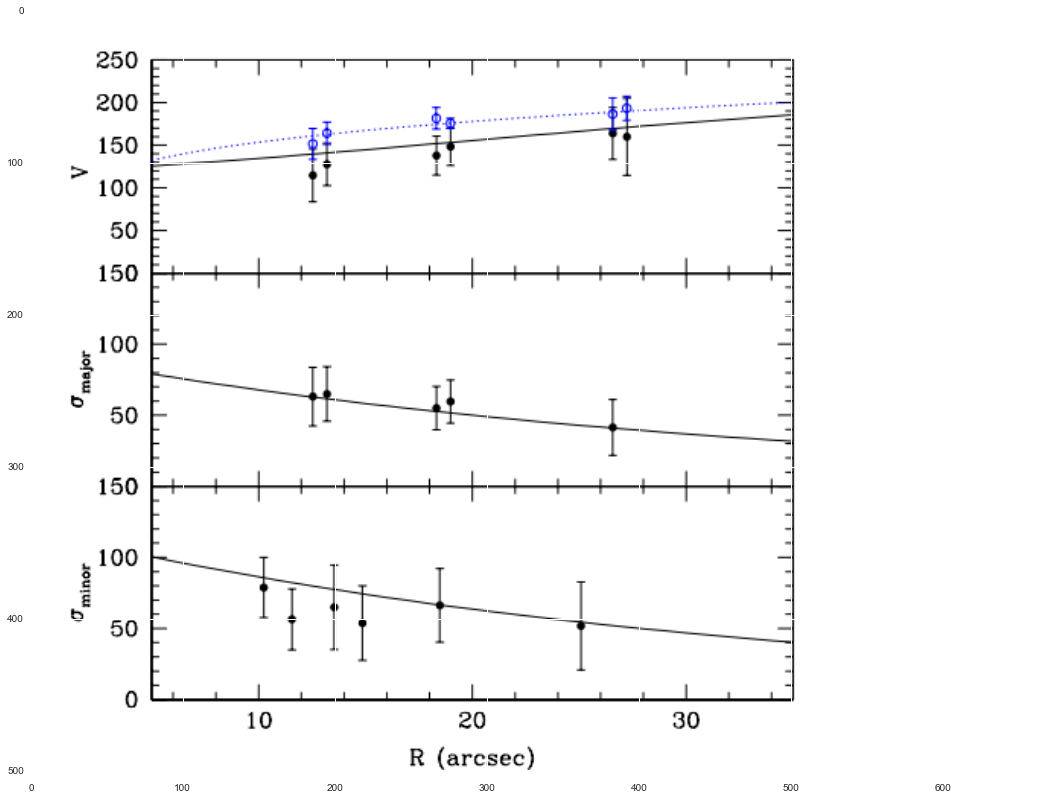

In [35]:
os.chdir("C:\\science\\2FInstability\\data\\ngc2280")

plt.imshow(np.asarray(Image.open("fig.png")))
plt.plot()

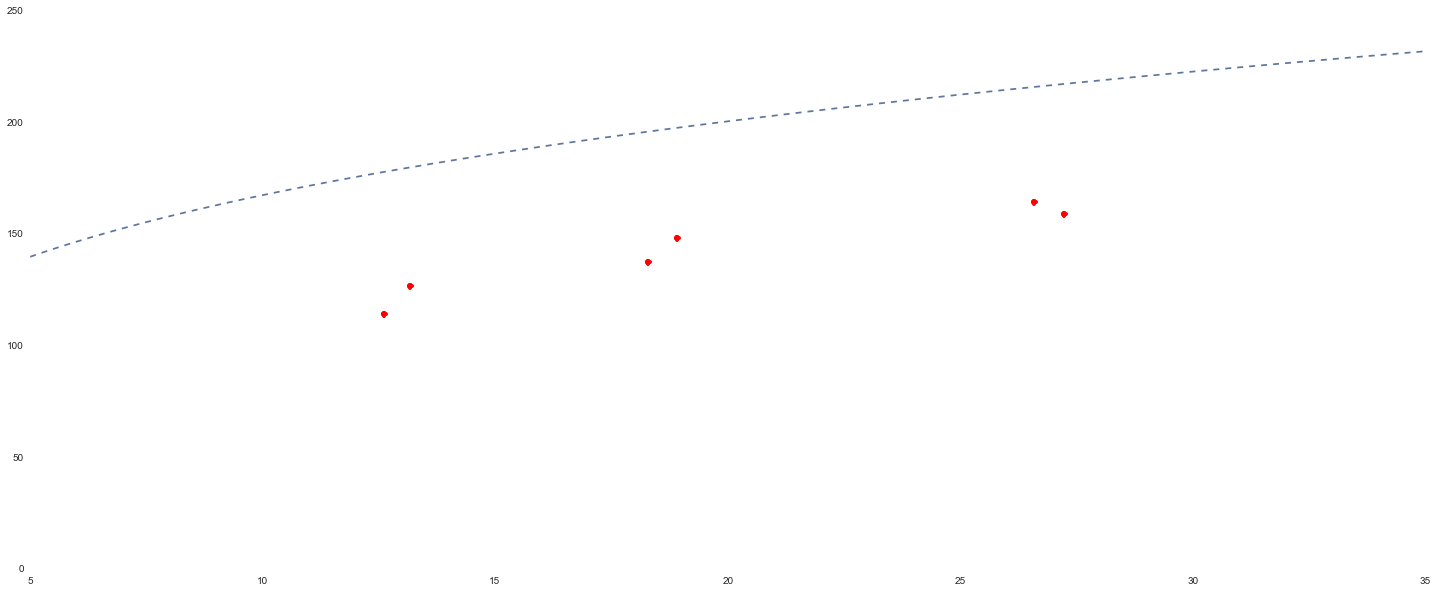

In [36]:
pylab.rcParams['figure.figsize'] = 25, 10

#Velocity
lu = (80, 62)
lu_val = (5, 200)
rd = (432, 174)
rd_val = (30, 0)

data = [(187,110), (195,103), (267,97), (276,91), (384,82), (393,85)]

def extend_values(data, lu, lu_val, rd, rd_val):
    xscale = 1.0*(rd_val[0]-lu_val[0])/(rd[0]-lu[0])
    yscale = 1.0*(rd_val[1]-lu_val[1])/(lu[1]-rd[1])
    extended = []
    for d in data:
        extended.append((xscale*(d[0]-lu[0])+lu_val[0], yscale*(rd[1] - d[1])+rd_val[1]))
    return extended
        
e_data = extend_values(data, lu, lu_val, rd, rd_val)
plt.plot(zip(*e_data)[0],zip(*e_data)[1], 'or')

vel_fit = lambda l: 92.*np.power(l, 0.26)
plt.plot(np.linspace(5., 35., 100), map(vel_fit, np.linspace(5., 35., 100)), '--')
plt.ylim(0, 250)
plt.xlim(5, 35)
plt.show()

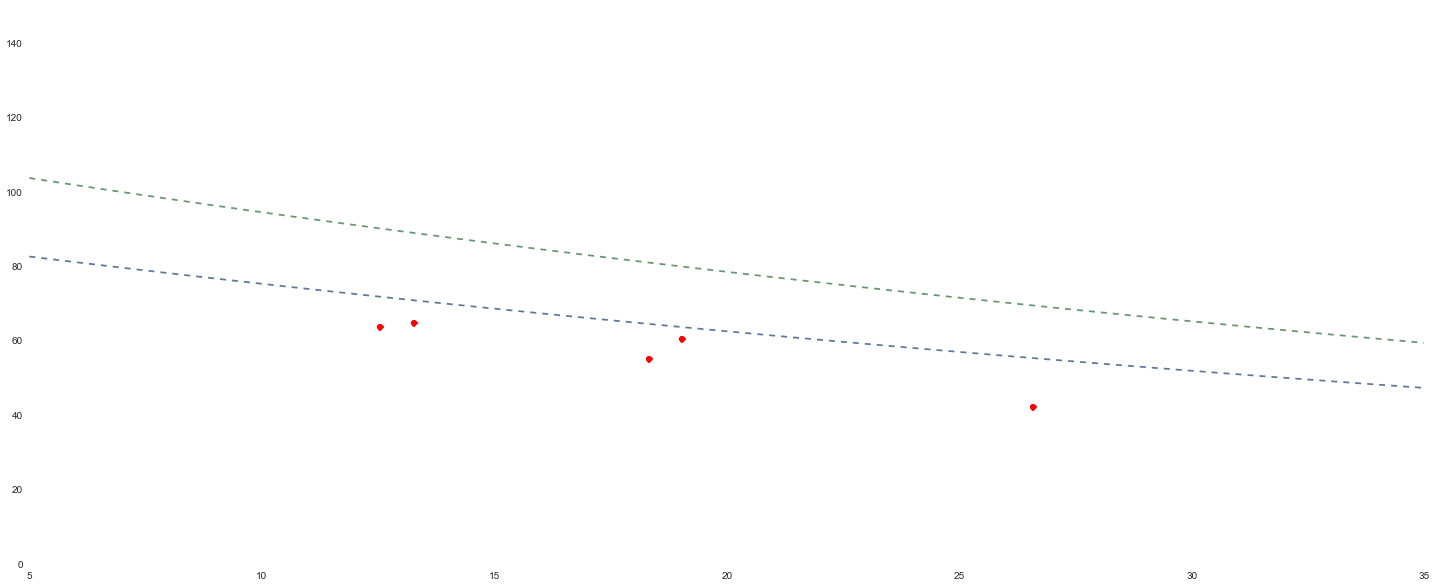

In [37]:
#Sig_maj
lu = (80, 174)
lu_val = (5, 150)
rd = (431, 315)
rd_val = (30, 0)

data = [(186,255), (196,254), (267,263), (277,258), (383,275)]

sig_maj_data = extend_values(data, lu, lu_val, rd, rd_val)
plt.plot(zip(*sig_maj_data)[0],zip(*sig_maj_data)[1], 'or')

sigR = lambda l: 126.*np.exp(-l/54.)
sigZ = lambda l: 31.*np.exp(-l/54.)
phi_to_R = lambda l: 0.5*(1 + 0.26)

sig_maj = lambda l: sigR(l)*sqrt((phi_to_R(l) * sin_i2 + sigZ(l)**2 * cos_i2/sigR(l)**2))
sig_min = lambda l: sqrt(sigR(l)**2 * sin_i2 + sigZ(l)**2 * cos_i2)

plt.plot(np.linspace(5., 35., 100), map(sig_maj, np.linspace(5., 35., 100)), '--')
plt.plot(np.linspace(5., 35., 100), map(sig_min, np.linspace(5., 35., 100)), '--')
plt.ylim(0, 150)
plt.xlim(5, 35)
plt.show()

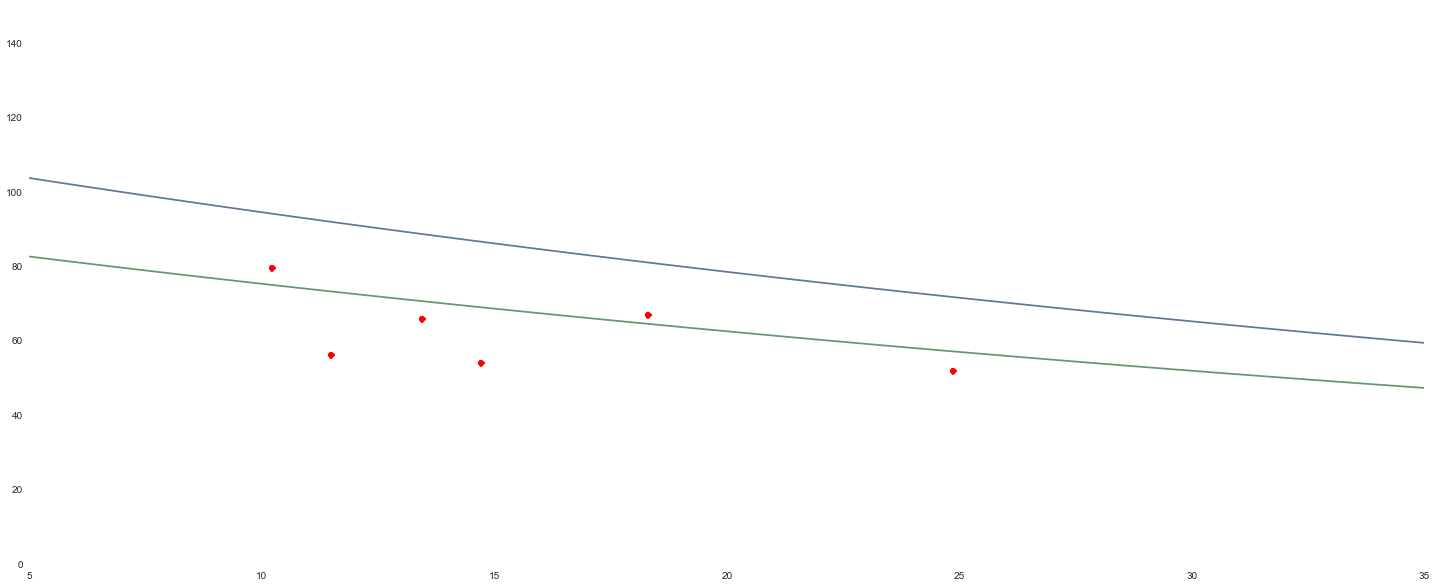

In [38]:
#Sig_min
lu = (80, 314)
lu_val = (5, 150)
rd = (435, 455)
rd_val = (30, 0)

data = [(154,380), (172,402), (200,393), (218,404), (269,392), (362,406)]

sig_min_data = extend_values(data, lu, lu_val, rd, rd_val)
plt.plot(zip(*sig_min_data)[0], zip(*sig_min_data)[1], 'or')

plt.plot(np.linspace(5., 35., 100), map(sig_min, np.linspace(5., 35., 100)), '-')
plt.plot(np.linspace(5., 35., 100), map(sig_maj, np.linspace(5., 35., 100)), '-')
plt.ylim(0, 150)
plt.xlim(5, 35)
plt.show()

In [39]:
h_kin = 54.
beta = -0.26

def sig_maj_exp(R):
    global alpha, sigR_0, h_kin, beta
    return np.exp(-R/h_kin)*sigR_0*sqrt(0.5*(1 - beta) * sin_i2 + alpha**2 * cos_i2)

def sig_min_exp(R):
    global alpha, sigR_0, h_kin
    return np.exp(-R/h_kin)*sigR_0*sqrt(sin_i2 + alpha**2 * cos_i2)

alphas = np.arange(0.01, 1., 0.01)
sigmas = np.arange(10.0, 150, 0.25)

def compute_chi2_maps(alph=(), sigm=()):
    '''Вычисляем все изображения, чтобы потом только настройки менять'''
    image_min = np.random.uniform(size=(len(sigm), len(alph)))
    image_maj = np.random.uniform(size=(len(sigm), len(alph)))
    image = np.random.uniform(size=(len(sigmas), len(alphas)))
    for i,si in enumerate(sigm):
        for j,al in enumerate(alph):
            global alpha, sigR_0
            alpha = al
            sigR_0 = si
            sqerr_maj = sum(power([sig_maj_exp(p[0]) - p[1] for p in sig_maj_data], 2))/len(sig_maj_data)
            sqerr_min = sum(power([sig_min_exp(p[0]) - p[1] for p in sig_min_data], 2))/len(sig_min_data)
            image_maj[i][j] = sqerr_maj
            image_min[i][j] = sqerr_min
    return image_maj, image_min

pics_path = "C:\\science\\2FInstability\\data\\ngc2280\\"
if not os.path.exists(pics_path):
    os.makedirs(pics_path)
if os.path.isfile(pics_path + 'chi2_map_maj.npy'):
    image_maj = np.load(pics_path + "chi2_map_maj.npy")
    image_min = np.load(pics_path + "chi2_map_min.npy")
else:
    image_maj, image_min = compute_chi2_maps(alph=alphas, sigm=sigmas)
    np.save(pics_path + 'chi2_map_maj', image_maj)
    np.save(pics_path + 'chi2_map_min', image_min)

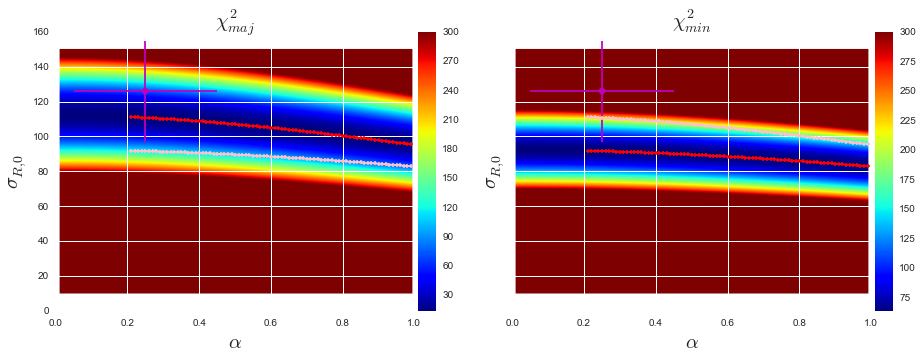

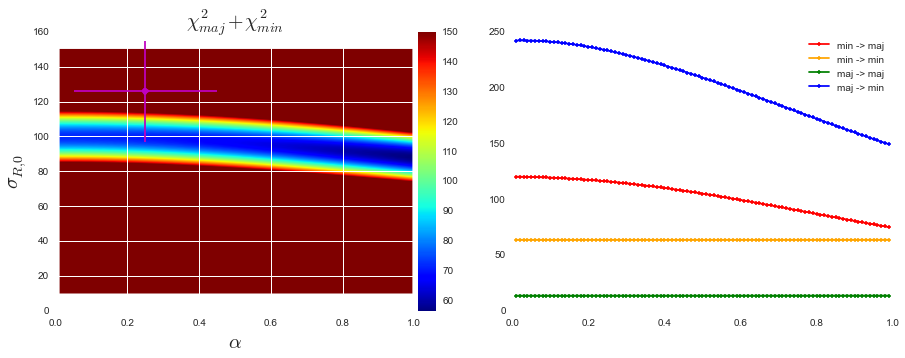

In [40]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_chi2_map(image, ax, log_scale=False, title='$\chi^2$', is_contour=False, vmax=0.):
    if image is not None:
        im = ax.imshow(image, cmap='jet', vmin=image.min(), vmax=vmax, interpolation='spline16', 
                   origin="lower", extent=[alphas[0], alphas[-1],sigmas[0],sigmas[-1]], aspect="auto")
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        ax.set_title(title, size=20.)
        ax.set_ylabel('$\sigma_{R,0}$', size=20.)
        ax.set_xlabel(r'$\alpha$', size=20.)
        ax.grid(True)
        
min_sigmas = numpy.where(image_min < image_min.min() + 10.)
slice_alph, slice_sig = min_sigmas[1], min_sigmas[0]
slice_alph = map(lambda l: alphas[0] + (alphas[-1] - alphas[0])*l/len(image_min[0]) , slice_alph)
slice_sig = map(lambda l: sigmas[0] + (sigmas[-1] - sigmas[0])*l/len(image_min), slice_sig)
poly_slice_min = poly1d(polyfit(slice_alph, slice_sig, deg=3))
maj_sigmas = numpy.where(image_maj < image_maj.min() + 10.)
slice_alph, slice_sig = maj_sigmas[1], maj_sigmas[0]
slice_alph = map(lambda l: alphas[0] + (alphas[-1] - alphas[0])*l/len(image_maj[0]) , slice_alph)
slice_sig = map(lambda l: sigmas[0] + (sigmas[-1] - sigmas[0])*l/len(image_maj), slice_sig)
poly_slice_maj = poly1d(polyfit(slice_alph, slice_sig, deg=3))
       
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=[15,5])
plot_chi2_map(image_maj, axes[0], log_scale=False, title='$\chi^2_{maj}$', is_contour=False, vmax=300.)
plot_chi2_map(image_min, axes[1], log_scale=False, title='$\chi^2_{min}$', is_contour=False, vmax=300.)
axes[0].plot(0.25, 126., 'o', color='m')
axes[0].errorbar(0.25, 126., xerr=0.2, yerr=29., fmt='.', marker='.', mew=0, color='m')
axes[0].plot(alphas[20:], map(poly_slice_maj, alphas[20:]), '.-', label = 'maj -> maj', color= 'red')
axes[0].plot(alphas[20:], map(poly_slice_min, alphas[20:]), '.-', label = 'min -> maj', color= 'pink')
axes[1].plot(0.25, 126., 'o', color='m')
axes[1].errorbar(0.25, 126., xerr=0.2, yerr=29., fmt='.', marker='.', mew=0, color='m')
axes[1].plot(alphas[20:], map(poly_slice_min, alphas[20:]), '.-', label = 'min -> min', color='red')
axes[1].plot(alphas[20:], map(poly_slice_maj, alphas[20:]), '.-', label = 'maj -> min', color='pink') 
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=[15,5])
plot_chi2_map((image_min + image_maj)/2, axes[0], log_scale=False, title='$\chi^2_{maj}+\chi^2_{min}$', is_contour=False, vmax=150.)
axes[0].plot(0.25, 126., 'o', color='m')
axes[0].errorbar(0.25, 126., xerr=0.2, yerr=29., fmt='.', marker='.', mew=0, color='m')

err_maj_1, err_maj_2 = [], []
err_min_1, err_min_2 = [], []
for al in alphas:
    global alpha, sigR_0
    alpha = al
    sigR_0 = poly_slice_min(alpha)
    err_maj_1.append(sum(power([sig_maj_exp(p[0]) - p[1] for p in sig_maj_data], 2))/len(sig_maj_data))
    err_min_1.append(sum(power([sig_min_exp(p[0]) - p[1] for p in sig_min_data], 2))/len(sig_min_data))
    sigR_0 = poly_slice_maj(alpha)
    err_maj_2.append(sum(power([sig_maj_exp(p[0]) - p[1] for p in sig_maj_data], 2))/len(sig_maj_data))
    err_min_2.append(sum(power([sig_min_exp(p[0]) - p[1] for p in sig_min_data], 2))/len(sig_min_data))
    
axes[1].plot(alphas, err_maj_1, '.-', label = 'min -> maj', color= 'red')
axes[1].plot(alphas, err_min_1, '.-', label = 'min -> min', color='orange')
axes[1].plot(alphas, err_maj_2, '.-', label = 'maj -> maj', color= 'green')
axes[1].plot(alphas, err_min_2, '.-', label = 'maj -> min', color='blue') 
axes[1].legend()

plt.show()

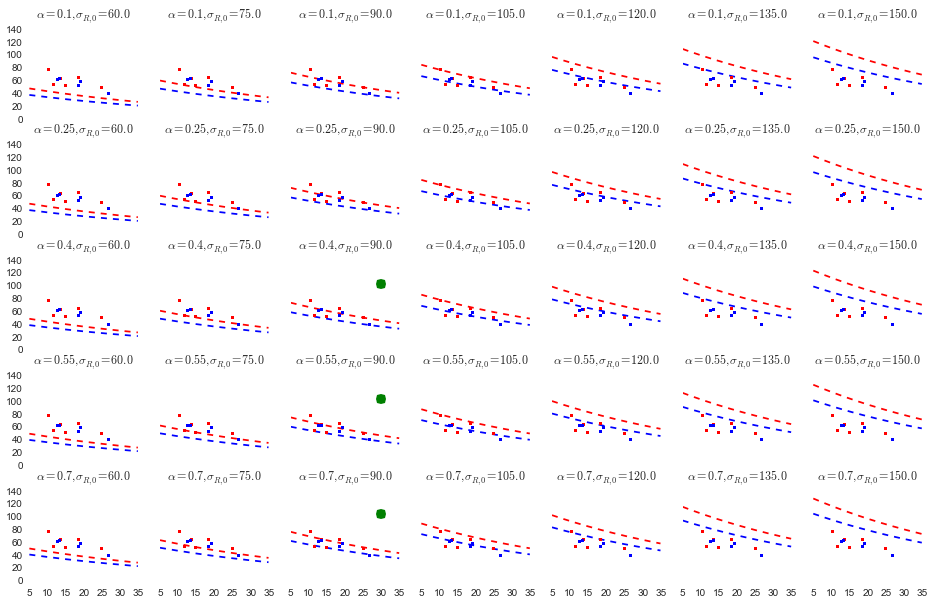

In [41]:
alphas = np.arange(0.1, 0.8, 0.15)
sigmas = np.arange(60., 160., 15.)
points = np.arange(5., 35., 0.1)
good_pics = []

def plot_ranges_gers(sigmas_range, alphas_range, good_pics=[], calc_chi=False, best_err=3):
    nrows = alphas.size
    ncols = sigmas.size
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=[16,10])
    plt_index = 0
    # Последнее - среднее геометрическое
    sqerr_majs, sqerr_mins, sqerr_mean = [],[],[]
    for al in alphas_range:
        for si in sigmas_range:
            global alpha, sigR_0
            alpha = al
            sigR_0 = si
            ax = axes[plt_index/ncols, plt_index % ncols]
            ax.set_title(r'$\alpha = %s, \sigma_{R,0}=%s$' % (al,si))
            
            sqerr_maj = sum(power([sig_maj_exp(p[0]) - p[1] for p in sig_maj_data], 2))/len(sig_maj_data)
            sqerr_min = sum(power([sig_min_exp(p[0]) - p[1] for p in sig_min_data], 2))/len(sig_min_data)
            if sqerr_maj < 120. and sqerr_min < 120.:
                ax.plot(30., 105., 'og', ms = 10)
            
            ax.plot(points, [sig_maj_exp(R) for R in points], '--', color='blue')
            ax.plot(points, [sig_min_exp(R) for R in points], '--', color='red')
            ax.plot(zip(*sig_min_data)[0],zip(*sig_min_data)[1], 's', color='red', ms=3)
            ax.plot(zip(*sig_maj_data)[0],zip(*sig_maj_data)[1], 's', color='blue', ms=3)
            ax.set_ylim(0, 150)
            ax.set_xlim(5, 35)
            plt_index = plt_index + 1
    

plot_ranges_gers(sigmas, alphas, good_pics=good_pics, calc_chi=True)
plt.show()

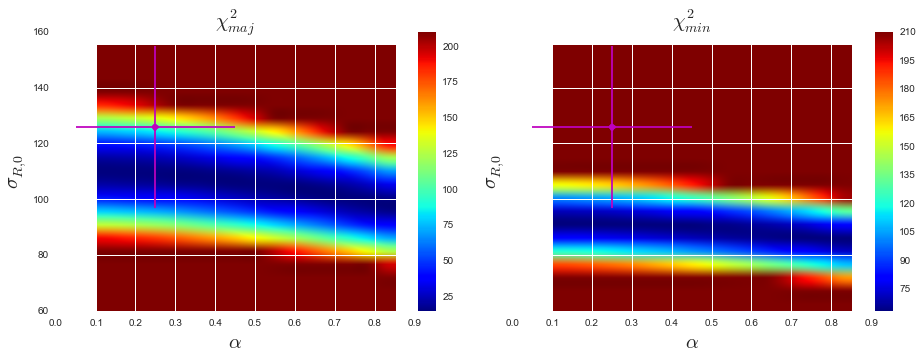

In [42]:
from IPython.html.widgets import *

def widget_plot_maps(h_k, b, vm, contour_swap):
    global alpha, sigR_0, h_kin, beta, alphas, sigmas
    h_kin = h_k
    beta = b
    alphas = np.arange(0.1, 0.9, 0.05)
    sigmas = np.arange(60.0, 160, 5.)
    image_maj, image_min = compute_chi2_maps(alph=alphas, sigm=sigmas)    
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=[15,5])
    plot_chi2_map(image_maj, axes[0], log_scale=False, title='$\chi^2_{maj}$', is_contour=False, vmax=vm)
    plot_chi2_map(image_min, axes[1], log_scale=False, title='$\chi^2_{min}$', is_contour=False, vmax=vm)
    
    if contour_swap:
        norm = cm.colors.Normalize(vmax=image_min.max(), vmin=-image_min.max())
        cmap = cm.PRGn
        levels = np.linspace(start=image_min.min(), stop=vm, num=10)
        cset=axes[0].contour(image_min, levels, hold='on', colors = 'k', origin='lower', 
                             extent=[alphas[0],alphas[-1],sigmas[0],sigmas[-1]])
        norm = cm.colors.Normalize(vmax=image_maj.max(), vmin=-image_maj.max())
        cmap = cm.PRGn
        levels = np.linspace(start=image_maj.min(), stop=vm, num=10)
        cset=axes[1].contour(image_maj, levels, hold='on', colors = 'k', origin='lower', 
                             extent=[alphas[0],alphas[-1],sigmas[0],sigmas[-1]])
    
    axes[0].plot(0.25, 126., 'o', color='m')
    axes[0].errorbar(0.25, 126., xerr=0.2, yerr=29., fmt='.', marker='.', mew=0, color='m')
    axes[1].plot(0.25, 126., 'o', color='m')
    axes[1].errorbar(0.25, 126., xerr=0.2, yerr=29., fmt='.', marker='.', mew=0, color='m')
    plt.show()

interact(widget_plot_maps, h_k=(15., 100., 2.), b=(-0.35, -0.15, 0.01), vm = (70., 350., 10),  contour_swap=False);